In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import random
import copy

In [2]:
class Graph:
    def __init__(self, s, t, V, E, Ef):
        self.vertices = V
        self.E = E
        self.E_f = Ef
        self.s = s
        self.t = t

        self.create_edges()
        self.create_adjacency_graph()

    def create_edges(self):
        edges = {}
        for e in self.E:
            u_v = str(e[0]) + ' ' + str(e[1])
            edges[u_v] = {'c': e[2], 'f': 0, 'cf': e[2], 'type': 'e', "color": 'black'}
        for e in self.E_f:
            u_v = str(e[0]) + ' ' + str(e[1])
            edges[u_v] = {'c': 0, 'f': 0, 'cf': 0, 'type': 'ef', "color": 'blue'}

        self.edges = edges

    def create_adjacency_graph(self):

        graph = {str(v): [] for v in self.vertices}
        for e in self.E:
            u = str(e[0])
            v = str(e[1])
            graph[u].append(v)
    
        #print(graph)
        self.adj = graph

#######################################################################

    def display_graph(self, typ=0):
        '''displays state of flow network'''
    
        G = nx.DiGraph()

        node_colors = []
        for v in self.vertices:
            if v == self.s:
                node_colors.append('red')
            elif v == self.t:
                node_colors.append("orange")
            else:
                node_colors.append('blue')
      
            G.add_node(str(v))

        edges = []
        for e in self.edges:
            e_s= e
            e0 = e_s.split(' ')
            edges += [(e0[0], e0[1], self.edges[e]['cf'])]
        G.add_weighted_edges_from(edges)

        colors = []
        for edge in G.edges():
            s, t = edge
            u_v = s + ' ' + t
            if typ == 0:
                colors.append(self.edges[u_v]['color'])
            else:
                colors.append(self.edges_2[u_v]['color'])

        pos = nx.shell_layout(G)
        e_labels = nx.get_edge_attributes(G, 'weight')
  
        nx.draw_networkx_nodes(G, pos, node_color=node_colors)
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos,  connectionstyle="arc3,rad=0.1", edge_color=colors)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=e_labels, label_pos=0.2, font_size=7)
        plt.axis('off')
        plt.show()

    def display_selected_path(self, path):
        '''colors chosen path to red'''
        self.edges_2 = copy.deepcopy(self.edges)

        n = len(path)
        for i in range(0, n-1):
            u = path[i]
            v = path[i+1]
            u_v = u + ' ' + v
            self.edges_2[u_v]['color'] = 'red'

        self.display_graph(typ=1)

    def display_flow_network(self):
        edges = []
        for e in self.edges:
            e_s = e
            e_s = e_s.split()
            if self.edges[e]['color'] == 'black':
                c = self.edges[e]['c']
                f = self.edges[e]['f']
                edges.append((e_s[0], e_s[1], f"{f} / {c}"))
        
        G = nx.DiGraph()

        G.add_weighted_edges_from(edges)

        node_colors = []
        for v in self.vertices:
            if v == self.s:
                node_colors.append('red')
            elif v == self.t:
                node_colors.append("orange")
            else:
                node_colors.append('blue')
      
            G.add_node(str(v))

        pos = nx.shell_layout(G)
        e_labels = nx.get_edge_attributes(G, 'weight')
  
        nx.draw_networkx_nodes(G, pos, node_color=node_colors)
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos,  connectionstyle="arc3,rad=0.1")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=e_labels)
        plt.axis('off')
        plt.show()

#######################################################################

    def Ford_Fulkerson(self, s, t):
        max_flow = 0
        paths = self.find_paths(s, t)
        print()

        while True:
            print("\nAvailable paths:")
            good_paths = self.give_options(paths)

            if len(good_paths) == 0:
                print("FINISHED.")
                break
            
            print("Choose path id, or write X if you want choose random one")
            s_id = input()
            if s_id == 'X':
                s_id = random.choice([i for i in range(0, len(good_paths))]) 

            path = good_paths[int(s_id)]
            print("\nSELECTED: {path}\n")

            self.display_selected_path(path)

            paths.remove(path)
            
            n = len(path)
            min_cf = float('inf')
            for i in range(0, n-1):
                u = path[i]
                v = path[i+1]
                u_v = u + ' ' + v
                
                value = self.edges[u_v]['cf']
                if value < min_cf:
                    min_cf = value
            
            print("MIN:", min_cf)
            max_flow += min_cf

            for i in range(0, n-1):
                u = path[i]
                v = path[i+1]
                u_v = u + ' ' + v
                v_u = v + ' ' + u

                self.edges[u_v]['f'] += min_cf
                self.edges[u_v]['cf'] -=  min_cf

                self.edges[v_u]['cf'] += min_cf
                self.edges[v_u]['f'] += self.edges[u_v]['f']


            self.display_graph(typ=0)
            self.display_flow_network()
            print('------')

        print("==========")
        print("MAX FLOW:", max_flow)
    

#######################################################################

    def give_options(self, paths):
        gp = self.check_paths(paths)
        for i in range(0, len(gp)):
            print("id:", i, ", path:", gp[i])
        return gp

    def check_paths(self, paths):
        good_paths = []
        for path in paths:
            n = len(path)
            min_cf = float('inf')
            for i in range(0, n-1):
                u = path[i]
                v = path[i+1]
                u_v = u + ' ' + v
                value = self.edges[u_v]['cf']
                if value < min_cf:
                    min_cf = value
                
            if min_cf > 0:
                good_paths += [path]
        
        return good_paths

#######################################################################

    def find_paths(self, s, t):    
        visited = {v: False for v in self.adj.keys()}
        
        self.paths = []
        path = []
        self.find_paths_visit(s, t, visited, path)

        i = 0
        n = len(self.paths) 
        path = []
        paths = []

        while i < n:
            path.append(self.paths[i])
            if self.paths[i] == 't':
                paths += [path]
                path = []
            i += 1
    
        print("PATHS:", paths)
        return paths
   
    def find_paths_visit(self, s, t, visited, path):
        visited[s] = True
        path.append(s)

        if s == t:
            self.paths += path 
        else:
            for v in self.adj[s]:
                if visited[v] == False:
                    self.find_paths_visit(v, t, visited, path)

        path.pop()
        visited[s] = False

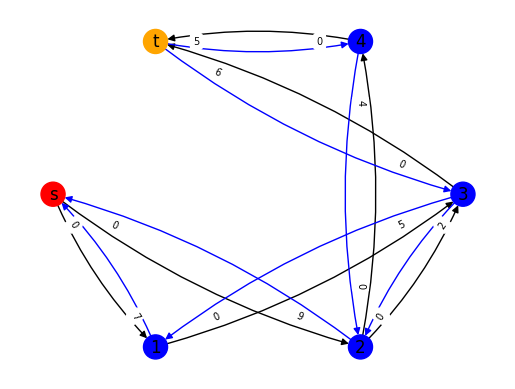

PATHS: [['s', '1', '3', 't'], ['s', '2', '3', 't'], ['s', '2', '4', 't']]


Available paths:
id: 0 , path: ['s', '1', '3', 't']
id: 1 , path: ['s', '2', '3', 't']
id: 2 , path: ['s', '2', '4', 't']
Choose path id, or write X if you want choose random one

SELECTED: {path}



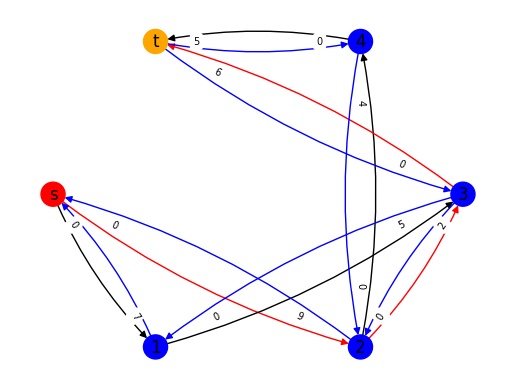

MIN: 2


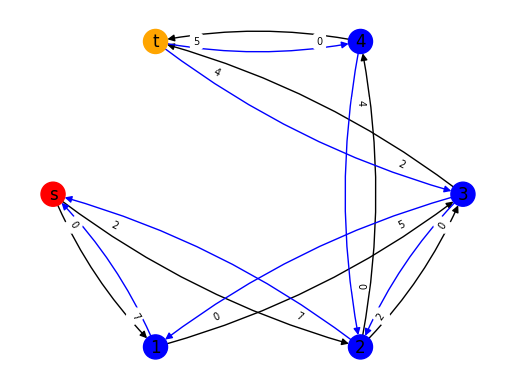

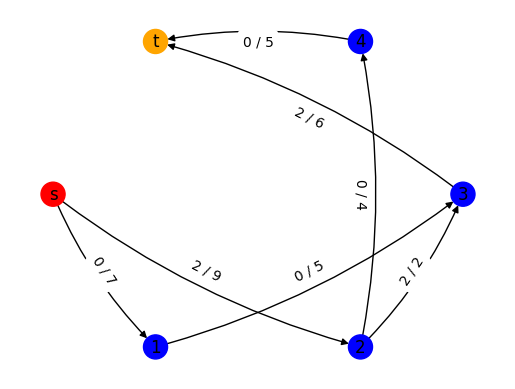

------

Available paths:
id: 0 , path: ['s', '1', '3', 't']
id: 1 , path: ['s', '2', '4', 't']
Choose path id, or write X if you want choose random one

SELECTED: {path}



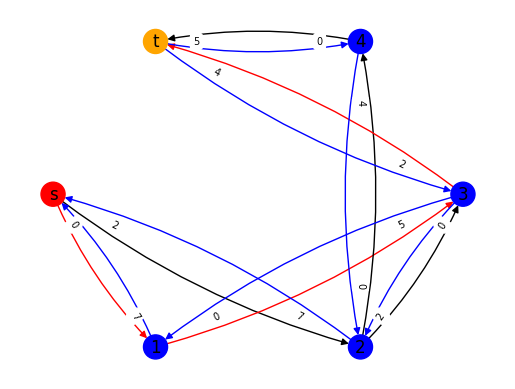

MIN: 4


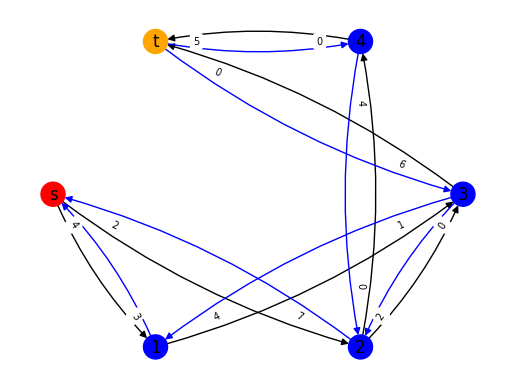

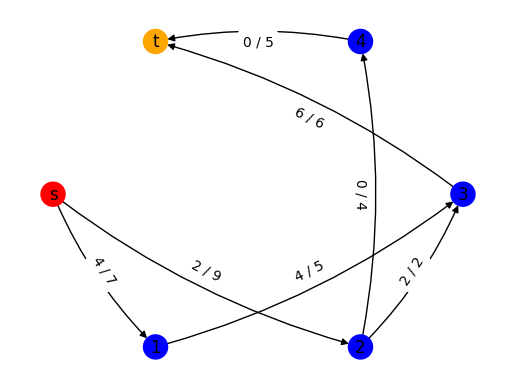

------

Available paths:
id: 0 , path: ['s', '2', '4', 't']
Choose path id, or write X if you want choose random one

SELECTED: {path}



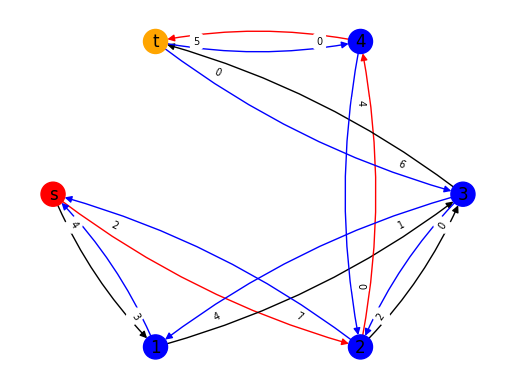

MIN: 4


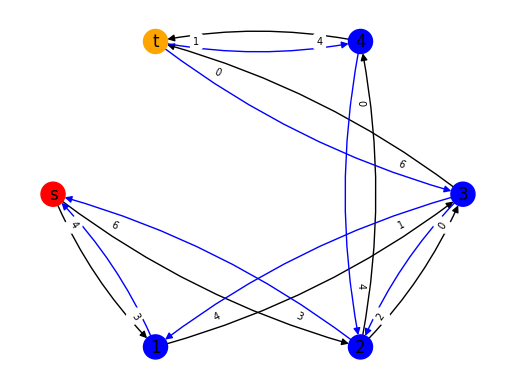

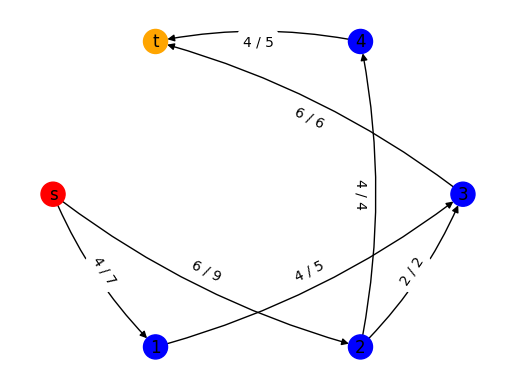

------

Available paths:
FINISHED.
MAX FLOW: 10


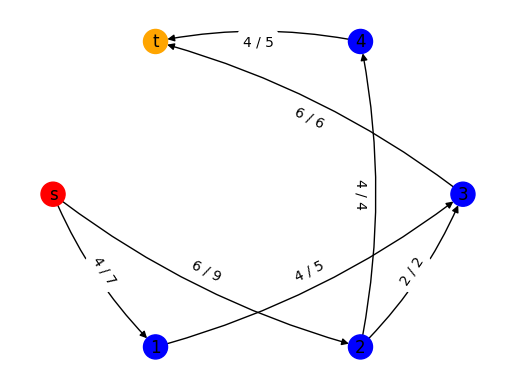

In [3]:
'''
#exemplary graph
V  = ['s', 2, 3, 4, 5, 't']
E  = [('s', 2, 5), ('s', 4, 7), (4, 2, 3), (2, 3, 3), (2, 5, 2), (4, 5, 4), (5, 3, 1), (3, 't', 9), (5, 't', 2)]
Ef = [(2, 's', 0), (4, 's', 0), (2, 4, 0), (3, 2, 0), (5, 2, 0), (5, 4, 0), (3, 5, 0), ('t', 3, 0), ('t', 5, 0)]

G = Graph('s', 't', V, E, Ef)
G.display_graph() 
G.Ford_Fulkerson('s', 't')
'''

#another graph
V = ['s', 1, 2, 3, 4, 't']
#E = [('s', 1, 9), ('s', 2, 8), (2, 1, 2), (1, 3, 4), (1, 4, 4), (2, 4, 5), (2, 't', 3), (4, 't', 6), (3, 't', 5)]
E = [('s', 1, 7), ('s', 2, 9), (1, 3, 5), (2, 3, 2), (2, 4, 4), (3, 't', 6), (4, 't', 5)]

Ef = []
for e in E:
    Ef.append((e[1], e[0], 0))


G = Graph('s', 't', V, E, Ef)
G.display_graph() 
G.Ford_Fulkerson('s', 't')

G.display_flow_network()